<p style = "font-size : 50px; color : #393e46 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #00adb5; border-radius: 5px 5px;"><strong>Customer Segmentation</strong></p>

> In this guide, we will focus on implementing the **KMeans, HAC, DBSCAN with Scikit-Learn** to solve a marketing problem, i.e., customer segmentation.

After reading the guide, you will understand:

- How to visualize the dataset to understand if it is fit for clustering.
- How to pre-process features and engineer new features based on the dataset.
- How to implement the KMeans, HAC, DBSCAN with Scikit-Learn.


In [1]:
# importing libraries

import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
import missingno as msno

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

Source of data: Kaggle https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [2]:
df = pd.read_csv('shopping-data_v2.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# dropping useless column

df.drop('CustomerID', axis = 1, inplace = True)

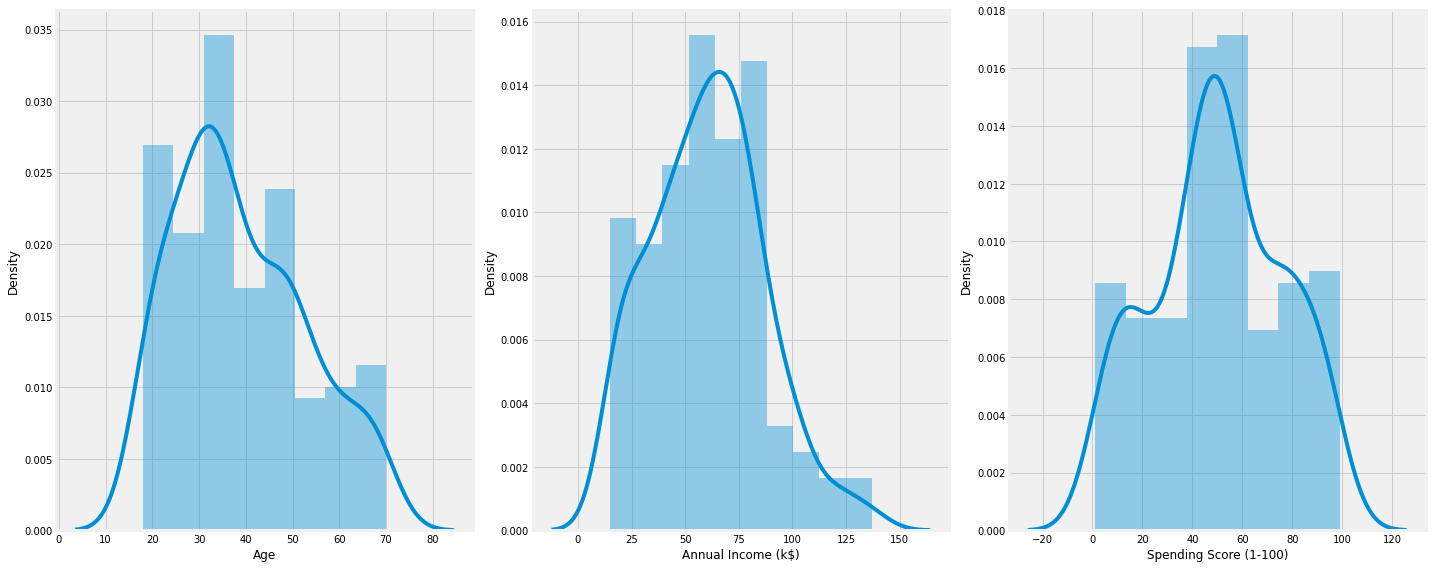

In [6]:
# distribution plots

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.distplot(df[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

<ul>
    <li style = "color : #03506f; font-size : 20px; font-family : 'Comic Sans MS';"><strong>Age group near 30-40 have the highest density.</strong></li>
    <li style = "color : #03506f; font-size : 20px; font-family : 'Comic Sans MS';"><strong>Most customers have income in range of 50-80k.</strong></li>
    <li style = "color : #03506f; font-size : 20px; font-family : 'Comic Sans MS';"><strong>Most of the customers have spending score of 50.</strong></li>
</ul>

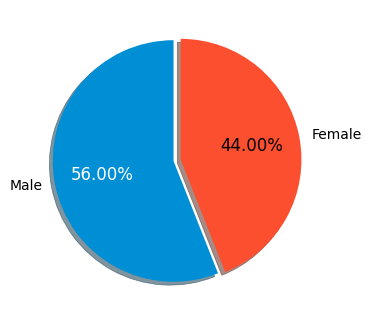

In [7]:
values = df['Gender'].value_counts()
labels = ['Male', 'Female']

fig, ax = plt.subplots(figsize = (4, 4), dpi = 100)
explode = (0, 0.06)

patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 90, explode = explode)

plt.setp(texts, color = 'black')
plt.setp(autotexts, size = 12, color = 'white')
autotexts[1].set_color('black')
plt.show()

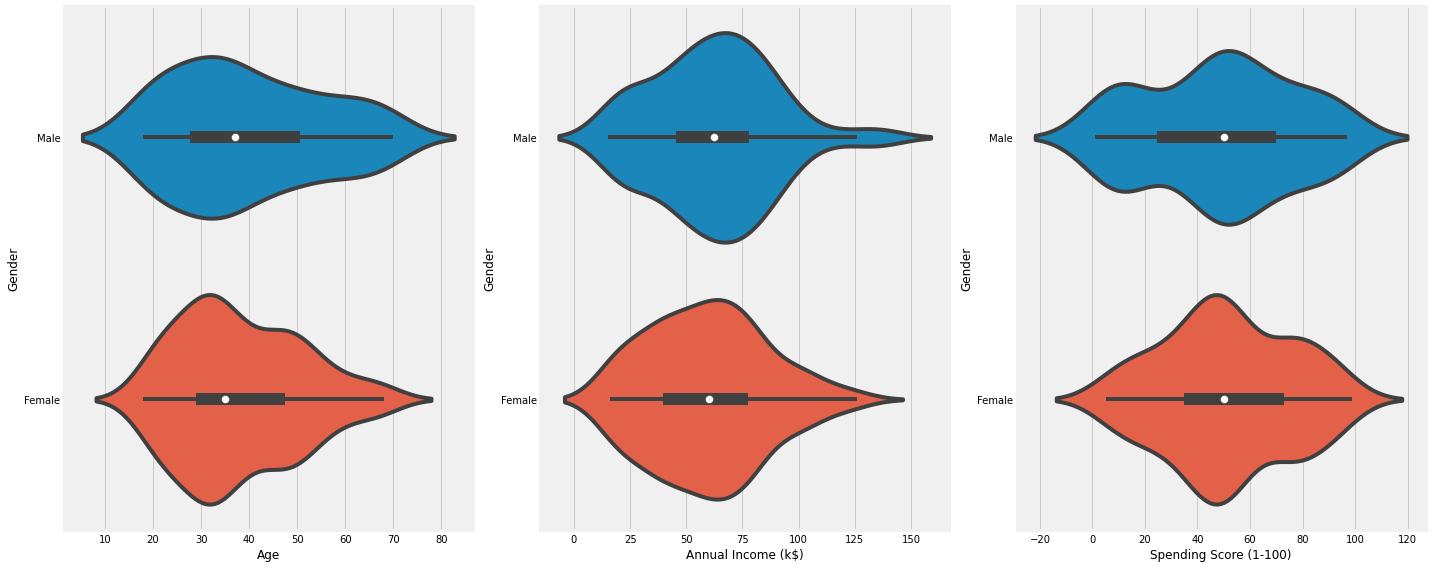

In [8]:
plt.figure(figsize = (20, 8))
plotnumber = 1

for col in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.violinplot(x = col, y = 'Gender', data = df)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

In [9]:
age_18_25 = df.Age[(df.Age >= 18) & (df.Age <= 25)]
age_26_35 = df.Age[(df.Age >= 26) & (df.Age <= 35)]
age_36_45 = df.Age[(df.Age >= 36) & (df.Age <= 45)]
age_46_55 = df.Age[(df.Age >= 46) & (df.Age <= 55)]
age_55above = df.Age[df.Age >= 55]

In [10]:
x_age = ['18-25', '26-35', '36-45', '46-55', '55+']
y_age = [len(age_18_25.values), len(age_26_35.values), len(age_36_45.values), len(age_46_55.values),
     len(age_55above.values)]

px.bar(data_frame = df, x = x_age, y = y_age, color = x_age,
       title = 'Number of customers per age group')

In [57]:
px.scatter(data_frame = df, x = 'Annual Income (k$)', y = 'Spending Score (1-100)',
          title = 'Relation between Annual Income and Spending Score')

<ul>
    <li style = "color : #03506f; font-size : 20px; font-family : 'Comic Sans MS';"><strong>There is no relation between the customers having annual income in the range of 20-40k and 80-140k but there is relation between customers who have annual income in the range of 40-60k.</strong></li>
</ul>

In [11]:
ss_1_20 = df['Spending Score (1-100)'][(df['Spending Score (1-100)'] >= 1) &
                                       (df['Spending Score (1-100)'] <= 20)]

ss_21_40 = df['Spending Score (1-100)'][(df['Spending Score (1-100)'] >= 21) &
                                       (df['Spending Score (1-100)'] <= 40)]

ss_41_60 = df['Spending Score (1-100)'][(df['Spending Score (1-100)'] >= 41) &
                                       (df['Spending Score (1-100)'] <= 60)]

ss_61_80 = df['Spending Score (1-100)'][(df['Spending Score (1-100)'] >= 61) &
                                       (df['Spending Score (1-100)'] <= 80)]

ss_81_100 = df['Spending Score (1-100)'][(df['Spending Score (1-100)'] >= 81) &
                                       (df['Spending Score (1-100)'] <= 100)]

x_ss = ['1-20', '21-40', '41-60', '61-80', '81-100']
y_ss = [len(ss_1_20.values), len(ss_21_40.values), len(ss_41_60.values), len(ss_61_80.values),
        len(ss_81_100.values)]

px.bar(data_frame = df, x = x_ss, y = y_ss, color = x_ss,
       title = 'Number of customers per Spending Score group')

<ul>
    <li style = "color : #03506f; font-size : 20px; font-family : 'Comic Sans MS';"><strong>Most of the customers spending score is between 41-60k.</strong></li>
</ul>

In [12]:
ai_0_30 = df['Annual Income (k$)'][(df['Annual Income (k$)'] >= 0) & (df['Annual Income (k$)'] <= 30)]
ai_31_60 = df['Annual Income (k$)'][(df['Annual Income (k$)'] >= 31)&(df['Annual Income (k$)'] <= 60)]
ai_61_90 = df['Annual Income (k$)'][(df['Annual Income (k$)'] >= 61)&(df['Annual Income (k$)'] <= 90)]
ai_91_120 = df['Annual Income (k$)'][(df['Annual Income (k$)']>= 91)&(df['Annual Income (k$)']<=120)]
ai_121_150 = df['Annual Income (k$)'][(df['Annual Income (k$)']>=121)&(df['Annual Income (k$)']<=150)]

x_ai = ['$ 0-30,000', '$ 30,001-60,000', '$ 60,001-90,000', '$ 90,001-120,000', '$ 120,000-150,000']
y_ai = [len(ai_0_30.values) , len(ai_31_60.values) , len(ai_61_90.values) , len(ai_91_120.values),
         len(ai_121_150.values)]

px.bar(data_frame = df, x = x_ai, y = y_ai, color = x_ai,
       title = 'Number of customers per Annual Income group')

<ul>
    <li style = "color : #03506f; font-size : 20px; font-family : 'Comic Sans MS';"><strong>Most of the customers annual income lies between 60k-90k.</strong></li>
</ul>

<p style = "font-size : 45px; color : #34656d ; font-family : 'Comic Sans MS'; text-align : center; background-color : #f9b208; border-radius: 5px 5px;"><strong>K-Means</strong></p> 

<ul>
    <li style = "color : #f54748; font-size : 25px; font-family : 'Comic Sans MS';"><strong>kmeans clustering using `Age` and `Spending Score` columns</strong></li>
</ul>

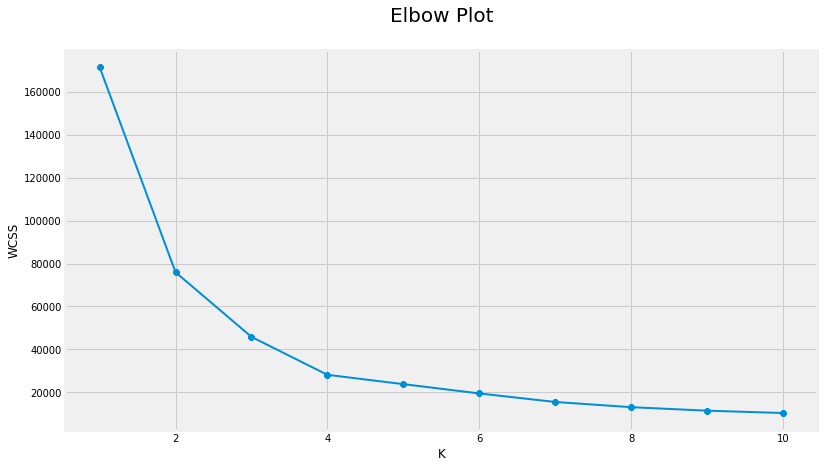

In [13]:
X1 = df.loc[:, ['Age', 'Spending Score (1-100)']].values

wcss= []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss, linewidth = 2, marker = '8')
plt.title('Elbow Plot\n', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

In [14]:
kmeans = KMeans(n_clusters = 4)
labels = kmeans.fit_predict(X1)
print(labels)

[3 2 0 2 3 2 0 2 0 2 0 2 0 2 0 2 3 3 0 2 3 2 0 2 0 2 0 3 0 2 0 2 0 2 0 2 0
 2 0 2 1 2 1 3 0 3 1 3 3 3 1 3 3 1 1 1 1 1 3 1 1 3 1 1 1 3 1 1 3 3 1 1 1 1
 1 3 1 3 3 1 1 3 1 1 3 1 1 3 3 1 1 3 1 3 3 3 1 3 1 3 3 1 1 3 1 3 1 1 1 1 1
 3 3 3 3 3 1 1 1 1 3 3 3 2 3 2 1 2 0 2 0 2 3 2 0 2 0 2 0 2 0 2 3 2 0 2 1 2
 0 2 0 2 0 2 0 2 0 2 0 2 1 2 0 2 0 2 0 2 0 3 0 2 0 2 0 2 0 2 0 2 0 2 0 2 3
 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2]


In [15]:
print(kmeans.cluster_centers_)

[[43.29166667 15.02083333]
 [55.70833333 48.22916667]
 [30.1754386  82.35087719]
 [27.61702128 49.14893617]]


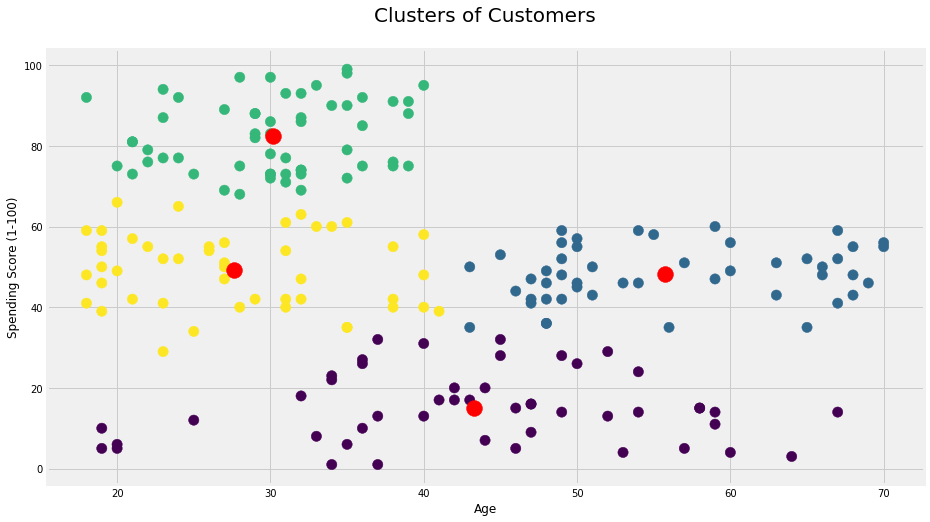

In [16]:
plt.figure(figsize = (14, 8))

plt.scatter(X1[:, 0], X1[:, 1], c = kmeans.labels_, s = 105)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', s = 250)
plt.title('Clusters of Customers\n', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

<ul>
    <li style = "color : #f54748; font-size : 25px; font-family : 'Comic Sans MS';"><strong>kmeans clustering using `Age` and `Annual Income` columns</strong></li>
</ul>

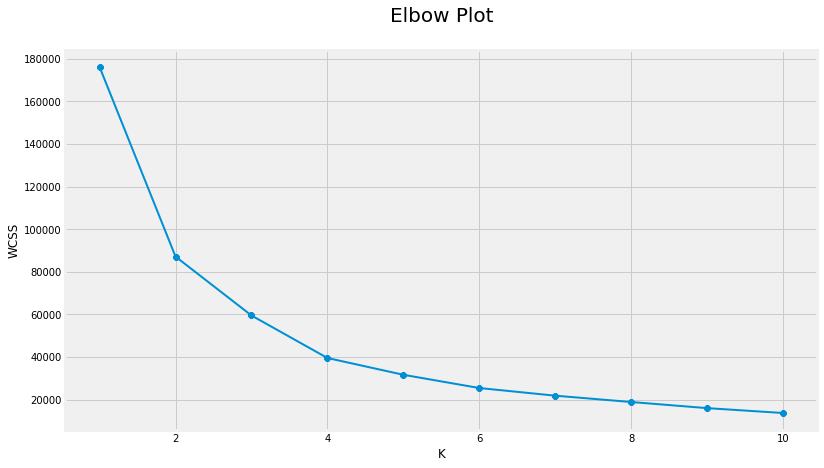

In [17]:
X2 = df.loc[:, ['Age', 'Annual Income (k$)']].values

wcss= []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(X2)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss, linewidth = 2, marker = '8')
plt.title('Elbow Plot\n', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

In [18]:
kmeans = KMeans(n_clusters = 5)
labels = kmeans.fit_predict(X2)
print(labels)

[1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 1 1
 1 1 1 2 1 2 1 2 1 2 1 1 1 2 1 1 2 2 2 2 2 4 2 2 4 2 2 2 4 2 2 4 4 2 2 2 2
 2 4 2 4 4 2 2 4 2 2 4 2 2 4 4 2 2 4 2 4 4 4 2 4 2 4 4 2 2 4 2 4 2 2 2 2 2
 4 4 4 4 4 2 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0 4 0 4 0 0 0 4 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [19]:
print(kmeans.cluster_centers_)

[[ 38.25862069  78.15517241]
 [ 29.53658537  27.24390244]
 [ 56.62        48.48      ]
 [ 36.6        109.7       ]
 [ 25.06451613  59.48387097]]


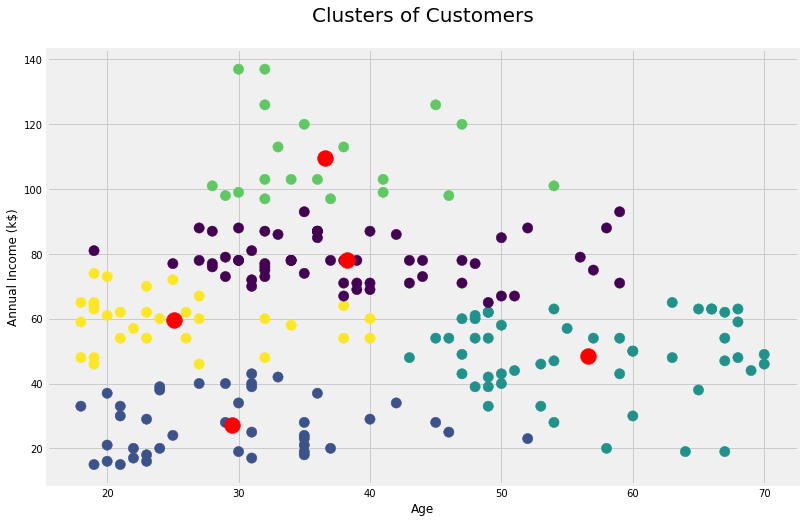

In [20]:
plt.figure(figsize = (12, 8))

plt.scatter(X2[:, 0], X2[:, 1], c = kmeans.labels_, s = 105)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', s = 250)
plt.title('Clusters of Customers\n', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show()

<ul>
    <li style = "color : #f54748; font-size : 25px; font-family : 'Comic Sans MS';"><strong>kmeans clustering using `Annual Income` and `Spending Score`</strong></li>
</ul>

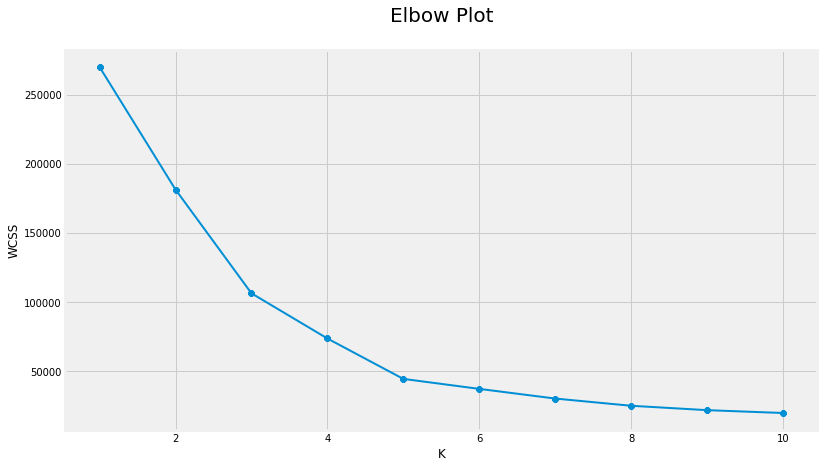

In [21]:
X3 = df.loc[:, ['Annual Income (k$)', 'Spending Score (1-100)']].values

wcss= []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss, linewidth = 2, marker = '8')
plt.title('Elbow Plot\n', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

In [22]:
kmeans = KMeans(n_clusters = 5)
labels = kmeans.fit_predict(X3)
print(labels)

[2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2
 4 2 4 2 4 2 0 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 3 1 0 1 3 1 3 1 0 1 3 1 3 1 3 1 3 1 0 1 3 1 3 1
 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1]


In [23]:
print(kmeans.cluster_centers_)

[[55.2962963  49.51851852]
 [86.53846154 82.12820513]
 [26.30434783 20.91304348]
 [88.2        17.11428571]
 [25.72727273 79.36363636]]


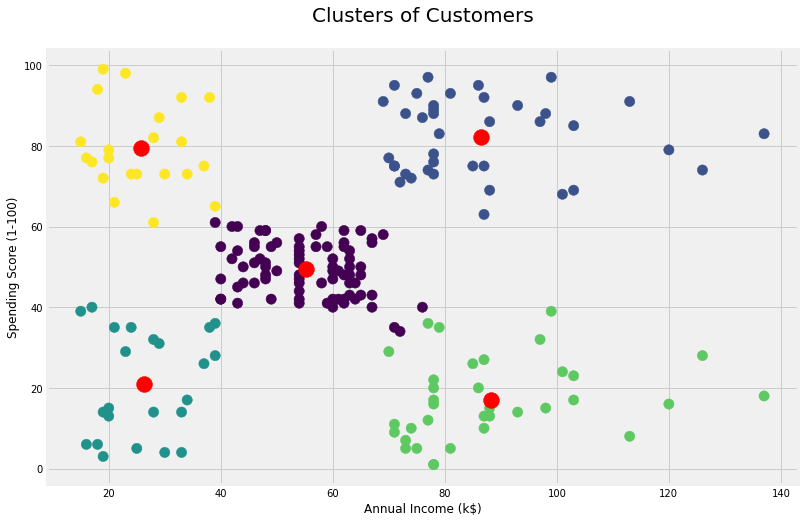

In [24]:
plt.figure(figsize = (12, 8))

plt.scatter(X3[:, 0], X3[:, 1], c = kmeans.labels_, s = 105)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', s = 250)
plt.title('Clusters of Customers\n', fontsize = 20)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

<ul>
    <li style = "color : #f54748; font-size : 25px; font-family : 'Comic Sans MS';"><strong>kmeans clustering using `Age`, `Annual Score` and `Spending Score`</strong></li>
</ul>

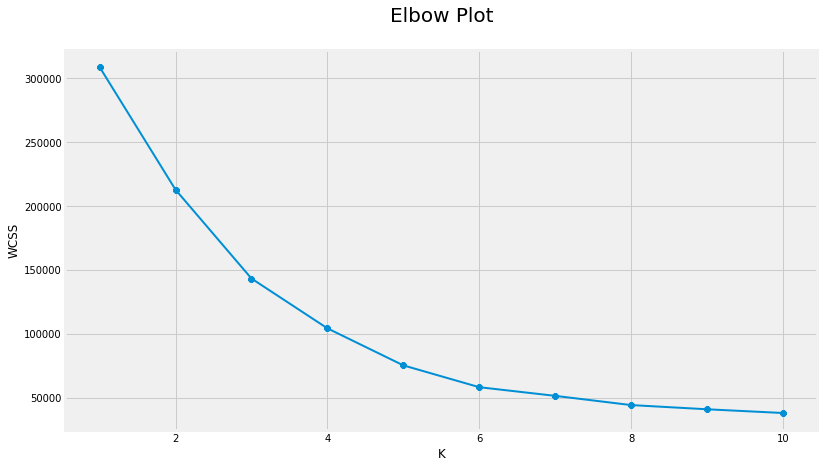

In [25]:
X4 = df.iloc[:, 1:]

wcss= []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(X4)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss, linewidth = 2, marker = '8')
plt.title('Elbow Plot\n', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

In [26]:
kmeans = KMeans(n_clusters = 6)
clusters = kmeans.fit_predict(X4)
X4['label'] = clusters

In [27]:
fig = px.scatter_3d(X4, x="Annual Income (k$)", y="Spending Score (1-100)", z="Age",
                    color = 'label', size = 'label')
fig.show()

<p style = "font-size : 45px; color : #34656d ; font-family : 'Comic Sans MS'; text-align : center; background-color : #f9b208; border-radius: 5px 5px;"><strong>Hierarchical Clustering</strong></p> 

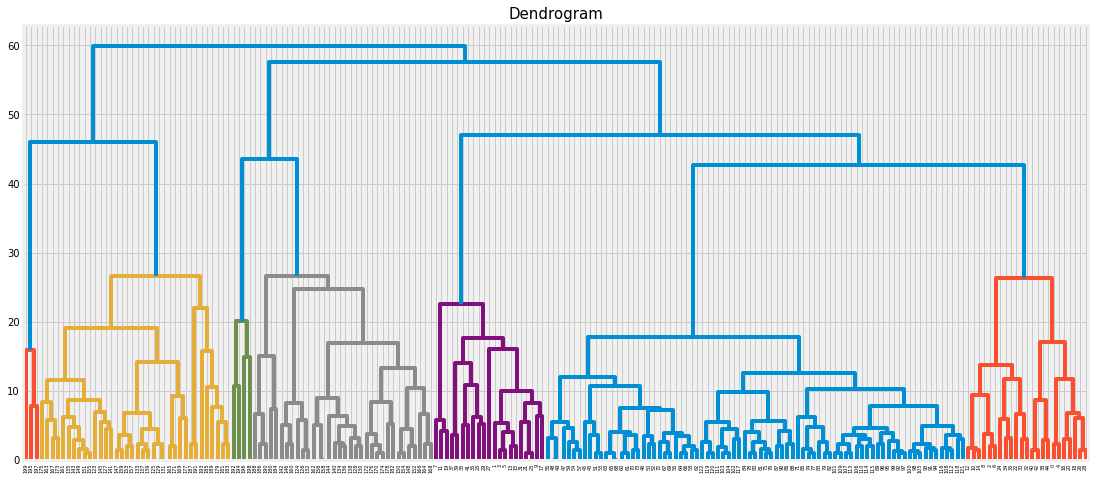

In [30]:
plt.figure(figsize = (17, 8))

dendo = dendrogram(linkage(X3, method = 'average', metric='euclidean'))
plt.title('Dendrogram', fontsize = 15)
plt.show()

In [31]:
agc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
labels = agc.fit_predict(X3)

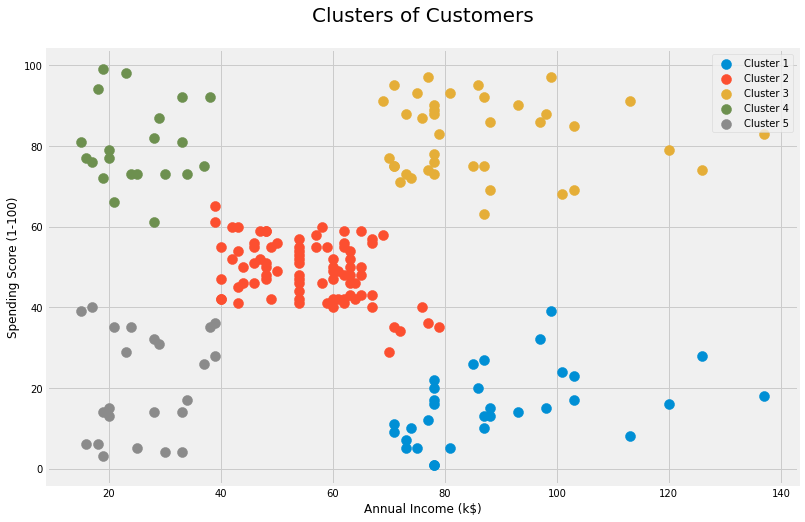

In [32]:
plt.figure(figsize = (12, 8))

plt.scatter(X3[labels == 0,0], X3[labels == 0,1], label = 'Cluster 1', s = 100)
plt.scatter(X3[labels == 1,0], X3[labels == 1,1], label = 'Cluster 2', s = 100)
plt.scatter(X3[labels == 2,0], X3[labels == 2,1], label = 'Cluster 3', s = 100)
plt.scatter(X3[labels == 3,0], X3[labels == 3,1], label = 'Cluster 4', s = 100)
plt.scatter(X3[labels == 4,0], X3[labels == 4,1], label = 'Cluster 5', s = 100)

plt.legend(loc = 'best')
plt.title('Clusters of Customers\n ', fontsize = 20)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

<p style = "font-size : 45px; color : #34656d ; font-family : 'Comic Sans MS'; text-align : center; background-color : #f9b208; border-radius: 5px 5px;"><strong>An Example of DBSCAN</strong></p> 

In [33]:
centers = [[1, 1], [-1, -1], [1, -1]]  
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, 
                            random_state=0)  # generate sample blobs

X = StandardScaler().fit_transform(X)

In [34]:
# DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

# we are calculating these for showcasing in diagram
# creating an array of true and false as the same size as db.labels
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)  
core_samples_mask[db.core_sample_indices_] = True  # setting the indices of the core regions to True
labels = db.labels_  # similar to the model.fit() method, it gives the labels of the clustered data

In [35]:
# Number of clusters in labels, ignoring noise if present.

# the label -1 is considered as noise by the DBSCAN algorithm
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
n_noise_ = list(labels).count(-1)  # calculating the number of clusters

In [37]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

"""Homogeneity metric of a cluster labeling given a ground truth.

A clustering result satisfies homogeneity if all of its clusters
contain only data points which are members of a single class."""

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953


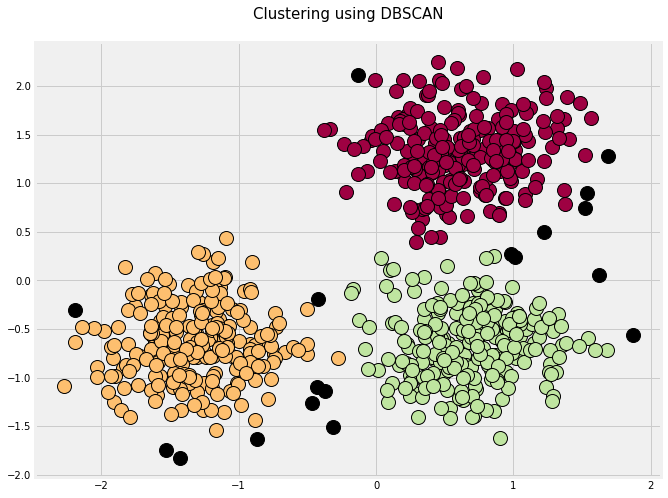

In [38]:
# Plot result
plt.figure(figsize = (10, 8))

# Black  is used for noise.
unique_labels = set(labels)  # identifying all the unique labels/clusters
colors = [plt.cm.Spectral(each)
          # creating the list of colours, generating the colourmap
          for each in np.linspace(0, 1, len(unique_labels))]  

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)   # assigning class members for each class
    xy = X[class_member_mask & core_samples_mask] # creating the list of points for each class  
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask] # creating the list of noise points   
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    
plt.title('Clustering using DBSCAN\n', fontsize = 15)
plt.show()